In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/autotrophy/'
m_fname = path.join(model_dir, 'glucose_auto_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_auto_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
lam.print_model()

Metabolites:
         NC  NOSC  internal                                               note
C_red     1   0.0         1            reduced C, 1 C of intracellular glucose
C_ox      1   4.0         0                      oxidized carbon carrier "CO2"
E_ox      1   0.0         0  oxidized e- donor/acceptor, O2, has fictional ...
E_red     1  -4.0         0  reduced donor/acceptor, 2 H2O, NC = 1 for bala...
EC       20   0.0         1          Oxidized two e- carrier with 20 carbons. 
ECH      20  -0.1         1  Reduced 2e- carrier, 20*-0.1 => 2 more e- than...
ADP      10   0.0         1                                                ADP
ATP      10   0.0         1                                                ATP
biomass   1   0.0         0                   Everything per C, default ZC = 0
Stoichiometries:
                   C_red  C_ox  E_ox  E_red   EC  ECH  ADP  ATP  biomass  \
process                                                                    
oxidation            0.0   0

In [3]:
# Do a quick run of the model to make sure it is feasible
lambda_max, opt_p = lam.maximize_lambda()
lambda_max

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


0.2683880597015248

In [4]:
# Run the model at various fixed lambda_hr values to calculate optimal phi values
p = lam.max_anabolic_rate_problem(fix_lambda=True)

phis = []
lambdas = np.logspace(-8, -3, 10)

for lam_val in lambdas:
    p.param_dict['lambda_hr'].value = lam_val
    res = p.solve()
    if p.status in ("infeasible", "unbounded"):
        phis.append(np.zeros(lam.S_df.index.size + 1))
        continue
    phis.append(p.var_dict['phis'].value.tolist() + [p.param_dict['phi_o'].value])    

colnames = lam.S_df.index.values.tolist() + ['other']
phi_df = pd.DataFrame(phis, columns=colnames)
phi_df['lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

,oxidation,reduction,anabolism,ATP_homeostasis,redox_homeostasis,other
lambda_hr,,,,,,
1.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0
3.593814e-08,0.0,0.0,0.0,0.0,0.0,0.0
1.291550e-07,0.0,0.0,0.0,0.0,0.0,0.0
4.641589e-07,0.0,0.0,0.0,0.0,0.0,0.0
1.668101e-06,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, '$\\phi$')

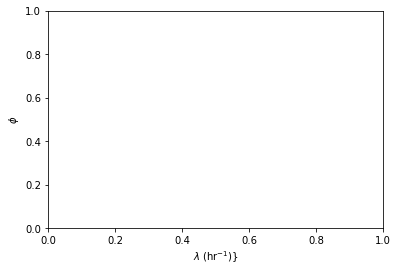

In [15]:
mask = (phi_df != 0).all(axis=1)
sns.lineplot(data=phi_df[mask])
plt.xlabel(r'$\lambda$ (hr$^{-1}$)}')
plt.ylabel(r'$\phi$')   

In [11]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_red", "ox_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

# Store the results in a dictionary for making a dataframe
res_dict = dict(ZCB=[], S6=[], phi_O=[], lambda_max=[], m_red=[],
                ox_ATP_per_e=[], m_ATP_homeostasis=[])
for p in list(lam.processes) + ['other']:
    res_dict['{0}_phi'.format(p)] = []
    res_dict['{0}_flux'.format(p)] = []

for phi_o, s6, m_red, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_red)
    lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('oxidation', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    res_dict['ZCB'].append(lam.ZCB)
    res_dict['S6'].append(s6)
    res_dict['phi_O'].append(phi_o)
    res_dict['m_red'].append(m_red)
    res_dict['ox_ATP_per_e'].append(atp_per_e)
    res_dict['m_ATP_homeostasis'].append(m_homeo)

    if max_lam == 0:
        res_dict['lambda_max'].append(0)
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(np.NaN)
            res_dict['{0}_flux'.format(process)].append(np.NaN)
        res_dict['other_phi'].append(np.NaN)
        res_dict['other_flux'].append(np.NaN)
    else:
        res_dict['lambda_max'].append(max_lam)

        phis = opt_prob.var_dict['phis'].value.copy()
        js = 3600*phis*lam.kcat_s/lam.m_Da
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(phis[k])
            res_dict['{0}_flux'.format(process)].append(js[k])
        res_dict['other_phi'].append(phis[-1])
        res_dict['other_flux'].append(np.NaN)

res_df = pd.DataFrame(res_dict)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,ZCB,S6,phi_O,lambda_max,m_red,ox_ATP_per_e,m_ATP_homeostasis,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,redox_homeostasis_phi,redox_homeostasis_flux,other_phi,other_flux
0,-0.141592,0.070796,0.340786,0.044435,908.237624,0.619758,343.952831,1.022349e-01,1.840229e-01,0.224206,0.044435,0.024686,0.044435,0.308083,0.161228,3.770852e-06,6.787534e-06,3.770852e-06,NaN
1,-0.141592,0.070796,0.465108,0.036054,908.237624,0.619758,343.952831,8.295124e-02,1.493122e-01,0.181922,0.036054,0.020030,0.036054,0.249983,0.130823,5.693363e-06,1.024805e-05,5.693363e-06,NaN
2,-0.751907,0.375953,0.340786,0.041467,908.237624,0.619758,343.952831,1.094661e-01,1.970389e-01,0.209231,0.041467,0.023037,0.041467,0.317476,0.166144,3.601394e-06,6.482509e-06,3.601394e-06,NaN
3,-0.141592,0.070796,0.340786,0.058414,269.188910,0.619758,343.952831,1.344032e-01,2.419258e-01,0.087357,0.058414,0.032452,0.058414,0.405001,0.211948,1.535451e-07,2.763812e-07,1.535451e-07,NaN
4,-0.141592,0.070796,0.340786,0.036942,908.237624,1.559916,343.952831,5.050298e-07,9.090536e-07,0.186399,0.036942,0.020523,0.036942,0.367293,0.192215,8.499784e-02,1.529961e-01,8.499784e-02,NaN


In [12]:
ps.set_results(res_df.lambda_max.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.045797  0.015731
S6                 0.023604  0.010907
m_red              0.156962  0.094583
ox_ATP_per_e       0.073851  0.033387
m_ATP_homeostasis  0.835842  0.334592
                         S1   S1_conf
phi_o              0.036197  0.093138
S6                -0.008914  0.051974
m_red              0.019239  0.136307
ox_ATP_per_e       0.091469  0.131512
m_ATP_homeostasis  0.783251  0.305214
                                         S2   S2_conf
(phi_o, S6)                       -0.040620  0.160307
(phi_o, m_red)                    -0.034267  0.139109
(phi_o, ox_ATP_per_e)             -0.041511  0.151768
(phi_o, m_ATP_homeostasis)         0.023568  0.244652
(S6, m_red)                        0.059415  0.073375
(S6, ox_ATP_per_e)                 0.030621  0.075326
(S6, m_ATP_homeostasis)            0.060925  0.110922
(m_red, ox_ATP_per_e)              0.104497  0.204808
(m_red, m_ATP_homeostasis)         0.106589  0.314718
(ox_

{'names': ['phi_o', 'S6', 'm_red', 'ox_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='m_red', ylabel='lambda_max'>

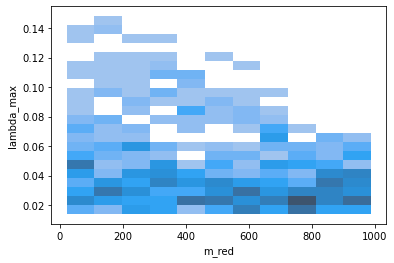

In [14]:
sns.histplot(data=res_df, y='lambda_max', x='m_red', legend=False)

<AxesSubplot: xlabel='m_ATP_homeostasis', ylabel='lambda_max'>

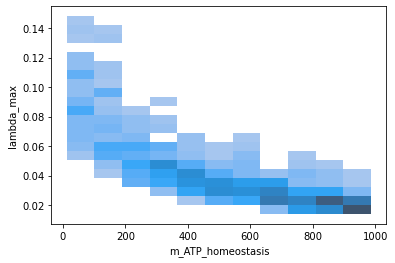

In [15]:
sns.histplot(data=res_df, y='lambda_max', x='m_ATP_homeostasis', legend=False)

In [8]:
mask = np.logical_and(res_df.lambda_max > 0.01, res_df.m_ATP_homeostasis > 500)
cols = 'ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi'.split(',')
res_df[mask][cols].sort_values('lambda_max', ascending=False)

,ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi
147,0.638037,-0.319019,0.346656,218.723564,0.806459,806.228089,0.031163,0.017313
526,-0.756272,0.378136,0.367011,377.922886,0.771510,667.657700,0.025639,0.014244
154,-0.155635,0.077817,0.415515,218.723564,0.537709,806.228089,0.024602,0.013668
519,-0.961982,0.480991,0.316111,377.922886,1.631939,667.657700,0.023781,0.013212
376,-0.072017,0.036008,0.393964,106.792603,0.346036,1094.283845,0.021305,0.011836
...,...,...,...,...,...,...,...,...
298,0.883846,-0.441923,0.314088,1958.435483,1.581503,2183.463037,0.010313,0.005729
532,0.384867,-0.192433,0.342501,542.561758,1.113789,2375.952948,0.010267,0.005704
332,-0.312863,0.156431,0.360248,6599.482794,1.456326,755.360324,0.010225,0.005681
288,0.526083,-0.263042,0.370897,3266.781434,0.223430,2183.463037,0.010172,0.005651


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


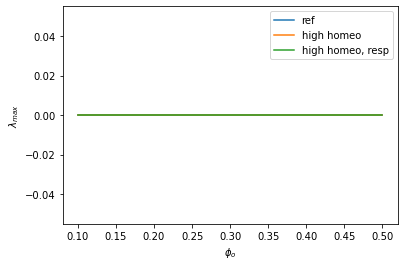

In [20]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline

high_homeo_resp_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_resp_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline
high_homeo_resp_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_resp_lambdas = [high_homeo_resp_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_resp_lambdas, label='high homeo, resp')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [21]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

for z in ZCBs:
    ref_lam.set_ZCB(z)
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, _ = ref_lam.maximize_lambda(phi_o=phi_o)
                    res_dict['ZCB'].append(z)
                    res_dict['phi_o'].append(phi_o)
                    res_dict['homeo_cost'].append(homeo_cost)
                    res_dict['lambda_max'].append(m)
                    res_dict['S6'].append(ref_lam.get_S6())
                    res_dict['resp_cost'].append(resp_cost)
                    res_dict['resp_ATP_per_e'].append(atp_per_e)
res_df = pd.DataFrame(res_dict)

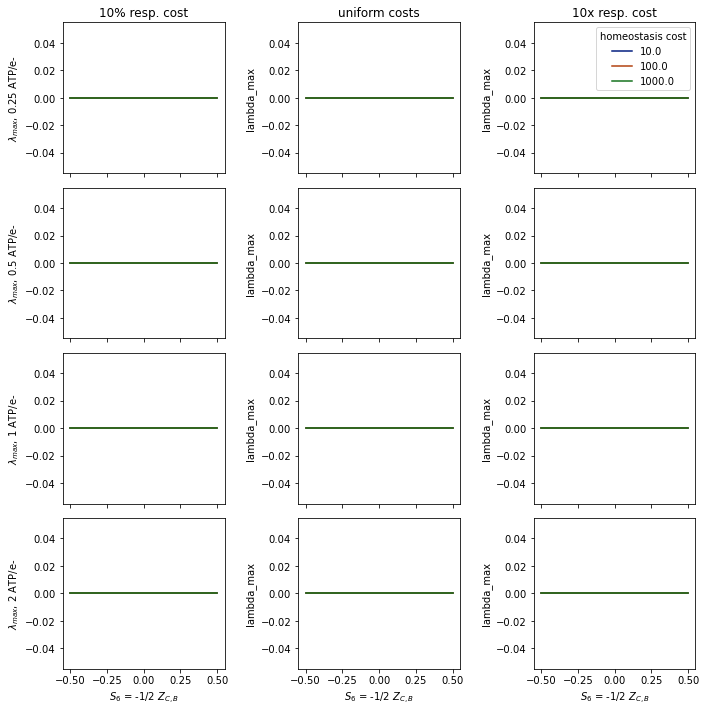

In [22]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.resp_cost == resp_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.resp_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_max', hue='homeo_cost', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()